#TASK1. 데이터 전처리

In [3]:
import pandas as pd
data= pd.read_csv("dataset_emotion.txt", sep=";", header=None, names=["text", "label"])
data.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [4]:
data= data.drop_duplicates()
print(data.shape)

(17999, 2)


중복된 데이터를 제거함. 총 17999개의 데이터가 남아있음. 그 외 결측치는 존재하지 않음.

#불용어 제거

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the missing resource
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
def remove_stopwords(text):
  words = word_tokenize(text.lower())
  filtered = [word for word in words if word not in stop_words]
  return ' '.join(filtered)

In [7]:
data1 = data['text'].apply(remove_stopwords)
data1.head()
data['text_removed'] = data1
data= data[['text_removed', 'label']]
data.head()

,text_removed,label
0,im feeling rather rotten im ambitious right,sadness
1,im updating blog feel shitty,sadness
2,never make separate ever want feel like ashamed,sadness
3,left bouquet red yellow tulips arm feeling sli...,joy
4,feeling little vain one,sadness


stopwords에 저장된 단어들이 잘 제거됐음을 확인할 수 있다.

#텍스트 데이터 인코딩(CountVectorizer, tf-idf)

**CountVectorizer**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_cv = vectorizer.fit_transform(data['text_removed'])
print(X_cv.shape)

(17999, 16015)


In [9]:
X_cv[3].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

17999개의 문장과 16015개의 고유단어가 존재함을 알 수 있음. (생각보다 고유단어 수가 적어 더블체크).

**tf-idf**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(data['text_removed'])

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data['label'])
data['label_encoded'] = y
data

,text_removed,label,label_encoded
0,im feeling rather rotten im ambitious right,sadness,4
1,im updating blog feel shitty,sadness,4
2,never make separate ever want feel like ashamed,sadness,4
3,left bouquet red yellow tulips arm feeling sli...,joy,2
4,feeling little vain one,sadness,4
...,...,...,...
17995,brief time beanbag said anna feel like beaten,sadness,4
17996,turning feel pathetic still waiting tables sub...,sadness,4
17997,feel strong good overall,joy,2
17998,feel like rude comment im glad,anger,0


'anger':0

'fear':1

'joy':2

'love':3

'sadness':4

'surprise':5

뚜렷한 감정이 드러나지 않을 때 -> neutral로 처리

꼭 love라는 단어가 포함되었다고 해서 그 감정이 아닐 수 있음(널 사랑하지 않아, 슬픔은 사치)-> 단어 간 문맥 파악 필요

너무 다양한 감정이 존재함

#TASK2. 피쳐 엔지니어링

감정분석의 경우 특수문자로 피처 엔지니어링을 진행할 수 있으나 해당 데이터에는 특수문자가 존재하지 않음..

단어 간 문맥을 반영하기 위해 CPU 환경의 word2vec 활용.

In [12]:
!pip install gensim

In [13]:
sentences = [text.split() for text in data['text_removed']]
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

sentence에 단어 리스트를 저장해두고 word2vec에 학습시킨다. 문맥으로 고려할 주변 단어의 범위는 5로 지정했다. 각 단어마다 벡터 생성.

In [15]:
import numpy as np

def sentence_vector(sentence, model):
    words = sentence.split()
    vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vecs, axis=0)
X_w2v = np.array([sentence_vector(text, w2v_model) for text in data['text_removed']])

이를 문장으로 확장. 문장 내 단어 벡터들의 평균값을 문장 벡터로 산출

텍스트 데이터를 수치형 피처로 변환.

모델에 입력하기 위해 Word2Vec을 활용하여 문장 단위 벡터를 생성함. 각 문장이 벡터로 표현되었으며 문맥 정보가 반영되게 함.

**모델링 결과 f1:0.28로 현저히 낮게 나와 word2vec문장 벡터를 tf-idf 가중평균으로 만드는 방식을 새롭게 채택**

In [32]:
tfidf_vocab = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
def weighted_sentence_vector(sentence, w2v_model, tfidf_vocab):
    words = sentence.split()
    vecs = []
    for word in words:
        if word in w2v_model.wv and word in tfidf_vocab:
            vecs.append(w2v_model.wv[word] * tfidf_vocab[word])
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

X_w2v_weighted = np.array([weighted_sentence_vector(text, w2v_model, tfidf_vocab)
                           for text in data['text_removed']])

y = data['label']

In [39]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(words=text.split(), tags=[str(i)])
             for i, text in enumerate(data['text_removed'])]

model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, epochs=20)
doc_vectors = np.array([model.dv[str(i)] for i in range(len(documents))])

#TASK1. 모델링

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=100)

로지스틱 회귀 계수를 통해 특정 단어가 특정 감정에 얼마나 영향을 주는지 파악. 이때 tf-idf 피처 사용함.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

랜덤 포레스트로 비선형 관계 학습. word2vec- 단어 의미 반영

In [33]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v_weighted, y, test_size=0.2, random_state=42
)

clf_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf_rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [41]:
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_encoded = le.fit_transform(data['label'])
documents = [TaggedDocument(words=text.split(), tags=[str(i)])
             for i, text in enumerate(data['text_removed'])]

doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, epochs=20)
X_docvec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])
X_train, X_test, y_train, y_test = train_test_split(
    X_docvec, y_encoded, test_size=0.2, random_state=42
)

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(" XGBoost (Doc2Vec)")
print(classification_report(y_test, y_pred, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost (Doc2Vec)
              precision    recall  f1-score   support

       anger       0.26      0.06      0.10       466
        fear       0.30      0.10      0.15       450
         joy       0.46      0.70      0.56      1196
        love       0.22      0.03      0.05       289
     sadness       0.39      0.53      0.45      1070
    surprise       0.33      0.01      0.02       129

    accuracy                           0.41      3600
   macro avg       0.33      0.24      0.22      3600
weighted avg       0.37      0.41      0.35      3600



#TASK2. 모델 평가

# TF-IDF -> Logistic Regression

In [29]:
y_pred = clf_lr.predict(X_test)
print(" Logistic Regression (TF-IDF)")
print(classification_report(y_test, y_pred))

 Logistic Regression (TF-IDF)
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       528
           1       0.84      0.77      0.80       411
           2       0.82      0.95      0.88      1178
           3       0.87      0.60      0.71       296
           4       0.89      0.93      0.91      1053
           5       0.89      0.44      0.59       134

    accuracy                           0.86      3600
   macro avg       0.87      0.75      0.79      3600
weighted avg       0.86      0.86      0.85      3600



정확도 0.86, F1 0.85로 전체적으로 우수한 성능. tf-idf 기반으로 단어 중요도가 반영되어 감정 분류가 잘 되었음을 확인할 수 있음.

하지만 클래스별로는 성능에 차이가 있음.

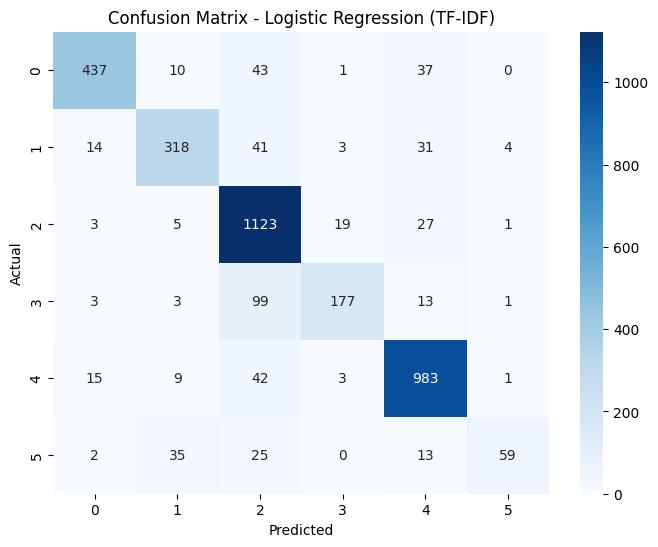

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (TF-IDF)')
plt.show()

클래스 5는 0.59로 낮은 성능을 보임. 클래스 5는 'surprise'로 아마 데이터 수가 적어 혼동이 발생했을 것으로 예상.

# TF-IDF 가중평균-> Random Forest

In [35]:
y_pred = clf_rf.predict(X_test)
print("Random Forest (Word2Vec TF-IDF 가중)")
print(classification_report(y_test, y_pred))

Random Forest (Word2Vec TF-IDF 가중)
              precision    recall  f1-score   support

       anger       0.28      0.03      0.05       466
        fear       0.32      0.04      0.07       450
         joy       0.37      0.71      0.49      1196
        love       0.10      0.00      0.01       289
     sadness       0.34      0.38      0.36      1070
    surprise       0.67      0.02      0.03       129

    accuracy                           0.36      3600
   macro avg       0.35      0.20      0.17      3600
weighted avg       0.33      0.36      0.29      3600



tf-idf 가중평균의 방식을 채택했는데도 0.28->0.29 로 현저히 낮은 f1-score.

원인 분석
 RF는 고차원 벡터에서 정보가 명확하지 않을 때 성능이 떨어진다고 함.
클래스가 많거나 불균형하여 F1이 떨어졌을 가능성.

이후 불용어 제거 전 단계의 데이터셋으로 doc2vec으로 벡터화 하여 xgboost를 적용한 결과 0.37까지 f1-score를 높일 수 있었음.

하지만 여전히 로지스틱 회귀가 월등히 성능이 좋음.